In [1]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

for fname in [
    "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/LSTM_Luong_attn.py",
    "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm_Luong_attn.py"
]:
  open(f"{fname}", "w").close()

In [4]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/LSTM_Luong_attn.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

class Seq2seqLSTM_Luong_attn(nn.Module):
    def __init__(self,
                 d_model: int,
                 n_encoder: int,
                 n_decoder: int,
                 dropout: int,
                 vocab
    ):
        super().__init__()

        self.vocab = vocab
        self.d_model = d_model
        self.n_encoder = n_encoder
        self.n_decoder = n_decoder
        self.decoder_dim = 2 * d_model # Kích thước hidden state của Decoder (2*d_model do Encoder Bi-LSTM)

        # 1. ENCODER (Bi-LSTM, Output: 2*d_model)
        self.src_embedding = nn.Embedding(
            num_embeddings=vocab.total_src_tokens,
            embedding_dim=d_model,
            padding_idx=vocab.pad_idx
        )
        self.encoder = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=n_encoder,
            batch_first=True,
            dropout=dropout,
            bidirectional=True # Encoder là Bidirectional
        )

        # 2. DECODER
        # Luong Chuẩn: tgt_embedding = d_model
        self.tgt_embedding = nn.Embedding(
            num_embeddings=vocab.total_tgt_tokens,
            embedding_dim=d_model, # Kích thước d_model
            padding_idx=vocab.pad_idx
        )

        # Luong Chuẩn: Decoder Input size chỉ cần d_model
        self.decoder = nn.LSTM(
            input_size=d_model, # Kích thước d_model (chỉ nhận embedding)
            hidden_size=self.decoder_dim, # 2*d_model
            num_layers=n_decoder,
            batch_first=True,
            dropout=dropout,
            bidirectional=False
        )

        # 3. ATTENTION (Luong General Attention: score(s_t, h_j) = s_t^T * W_a * h_j)
        # self.attn_weights đóng vai trò là ma trận W_a
        # Input: h_j (2*d_model), Output: W_a * h_j (2*d_model)
        self.attn_weights = nn.Linear(
            in_features=self.decoder_dim,
            out_features=self.decoder_dim,
            bias=False
        )

        # 4. CONTEXT-AWARE OUTPUT PROJECTION (s_t_tilde)
        # Input: [h_t_last_layer (2*d_model) ; context_vector (2*d_model)] -> 4*d_model
        # Output: 2*d_model
        self.context_projection = nn.Linear(
            in_features=4*d_model,
            out_features=self.decoder_dim
        )

        # 5. OUTPUT HEAD
        self.output_head = nn.Linear(
            in_features=self.decoder_dim, # 2*d_model
            out_features=vocab.total_tgt_tokens
        )

    def aligning(self, query: torch.Tensor, k_v: torch.Tensor) -> torch.Tensor:
        '''
        Tính Context Vector c_t theo Luong General Attention
        query: Trạng thái ẩn lớp cuối cùng của Decoder h_t (bs, 2*d_model)
        k_v: Các Annotation Vectors của Encoder h_j (bs, len, 2*d_model)
        '''
        # 1. Tính W_a * h_j
        attn_key = self.attn_weights(k_v) # (bs, len, 2*d_model)

        # 2. Tính Alignment Score: score = s_t^T * (W_a * h_j)
        query = query.unsqueeze(1) # (bs, 1, 2*d_model)
        a = torch.bmm(query, attn_key.transpose(1, 2)) # (bs, 1, len)

        # 3. Chuẩn hóa bằng Softmax -> Trọng số Attention (alpha_t)
        a = a.squeeze(1) # (bs, len)
        a = F.softmax(a, dim=1).unsqueeze(2) # (bs, len, 1)

        # 4. Tính Context Vector (Tổng có trọng số)
        context_vector = (a * k_v).sum(dim=1) # (bs, 2*d_model)

        return context_vector

    def forward_step(
        self,
        input_ids: torch.Tensor, # (bs, 1)
        enc_outputs: torch.Tensor, # (bs, len, 2*d_model)
        dec_states: Tuple[torch.Tensor, torch.Tensor] # (h_state, c_state)
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

        h_state, c_state = dec_states

        # 1. Chạy Decoder LSTM (Luong: Input chỉ là embedding)
        embedded_input = self.tgt_embedding(input_ids) # (bs, 1, d_model)
        _, (new_h_state, new_c_state) = self.decoder(embedded_input, (h_state, c_state))

        # 2. Tính Context Vector (c_t) TỪ h_t MỚI (new_h_state)
        new_last_h_state = new_h_state[-1] # (bs, 2*d_model)
        context_vector = self.aligning(new_last_h_state, enc_outputs) # (bs, 2*d_model)

        # 3. Tính Context-aware Output (s_t_tilde)
        # S_t_tilde = tanh(W_c [h_t_last_layer ; c_t])
        combined_output = torch.tanh(
            self.context_projection(
                torch.cat([new_last_h_state, context_vector], dim=-1) # (bs, 4*d_model)
            )
        ) # (bs, 2*d_model)

        return new_h_state.contiguous(), new_c_state.contiguous(), combined_output

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        self.train()
        embedded_x = self.src_embedding(x)
        bs, _, _ = embedded_x.shape

        # 1. Encoder
        enc_outputs, (enc_hn, enc_cn) = self.encoder(embedded_x)
        enc_hidden_states = enc_outputs

        # 2. Khởi tạo Trạng thái Decoder
        h_0 = enc_hn[-2:].transpose(0, 1).reshape(bs, -1)
        c_0 = enc_cn[-2:].transpose(0, 1).reshape(bs, -1)

        dec_h_state = h_0.unsqueeze(0).repeat(self.n_decoder, 1, 1)
        dec_c_state = c_0.unsqueeze(0).repeat(self.n_decoder, 1, 1)
        dec_states = (dec_h_state, dec_c_state)

        _, tgt_len = y.shape
        logits = []

        # 3. Decoding Loop (Teacher Forcing)
        for ith in range(tgt_len):
            y_ith = y[:, ith].unsqueeze(-1) # (bs, 1)

            dec_h_state, dec_c_state, combined_output = self.forward_step(
                y_ith,
                enc_hidden_states,
                dec_states
            )
            dec_states = (dec_h_state, dec_c_state) # Cập nhật trạng thái

            logit = self.output_head(combined_output) # (bs, total_tgt_tokens)
            logits.append(logit.unsqueeze(1))

        logits = torch.cat(logits, dim=1) # (bs, tgt_len, total_tgt_tokens)

        return logits

    def predict(self, x: torch.Tensor, max_len: int = 50):
        self.eval()
        with torch.no_grad():
            embedded_x = self.src_embedding(x)
            bs, _, _ = embedded_x.shape

            # 1. Encoder
            enc_outputs, (enc_hn, enc_cn) = self.encoder(embedded_x)
            enc_hidden_states = enc_outputs

            # 2. Khởi tạo Trạng thái Decoder
            h_0 = enc_hn[-2:].transpose(0, 1).reshape(bs, -1)
            c_0 = enc_cn[-2:].transpose(0, 1).reshape(bs, -1)
            dec_h_state = h_0.unsqueeze(0).repeat(self.n_decoder, 1, 1)
            dec_c_state = c_0.unsqueeze(0).repeat(self.n_decoder, 1, 1)
            dec_states = (dec_h_state, dec_c_state)

            y_ith = torch.zeros(bs, ).fill_(self.vocab.bos_idx).long().to(x.device).unsqueeze(-1)

            mark_eos = torch.zeros(bs, dtype=torch.bool).to(x.device)
            outputs = []

            for _ in range(max_len):
                dec_h_state, dec_c_state, combined_output = self.forward_step(
                    y_ith,
                    enc_hidden_states,
                    dec_states
                )
                dec_states = (dec_h_state, dec_c_state)

                logit = self.output_head(combined_output)
                y_ith = logit.argmax(dim=-1).long().unsqueeze(-1)

                mark_eos = mark_eos | (y_ith.squeeze(-1) == self.vocab.eos_idx)

                if all(mark_eos.tolist()):
                    break

                outputs.append(y_ith.squeeze(-1))

            if outputs:
                outputs = torch.stack(outputs, dim=1)
            else:
                outputs = torch.empty((bs, 0), dtype=torch.long, device=x.device)

            return outputs

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/LSTM_Luong_attn.py


In [5]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm_Luong_attn.py
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset # Thêm import cần thiết
import numpy as np
import os
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from phoMT import collate_fn, phoMTDataset
from vocab import Vocab
from LSTM_Luong_attn import Seq2seqLSTM_Luong_attn
# Import Metrics
try:
    from torchmetrics.text.rouge import ROUGEScore
except ImportError:
    print("Vui lòng cài đặt torchmetrics: pip install torchmetrics")
    exit()

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/3_LSTM_Luong_attn/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- Logging Setup ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(CHECKPOINT_DIR, "training.log"), mode='a'),
        logging.StreamHandler()
    ],
    force=True
)

def indices_to_text(indices, vocab, is_target=True):
    tokens = []
    # Chọn từ điển phù hợp
    i2s = vocab.tgt_i2s if is_target else vocab.src_i2s

    for idx in indices:
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        # Dừng nếu gặp <eos> (chỉ có trong Target/Translation)
        if is_target and idx == vocab.eos_idx:
            break

        if idx != vocab.pad_idx:
            # Bỏ qua <bos> chỉ cho Target/Translation
            if is_target and idx == vocab.bos_idx:
                continue

            # Dùng .get để an toàn, nếu không tìm thấy thì trả về <unk>
            token = i2s.get(idx, vocab.unk_token)
            tokens.append(token)

        # Dừng nếu gặp <eos> (chỉ có trong Source)
        if not is_target and idx == vocab.eos_idx:
             break

    return " ".join(tokens)

def train(model: nn.Module, dataloader: DataLoader, epoch: int, loss_fn, optimizer):
    model.train()
    running_loss = []

    with tqdm(dataloader, desc=f"Epoch {epoch} - Training") as pbar:
        for item in pbar:
            src = item['src'].to(device)
            tgt = item['tgt'].to(device)

            optimizer.zero_grad()

            # Teacher forcing
            decoder_input = tgt[:, :-1]
            targets = tgt[:, 1:]

            logits = model(src, decoder_input)

            # Flatten để tính loss
            # logits: (bs*len, vocab_size), targets: (bs*len)
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss.append(loss.item())
            pbar.set_postfix({"loss": np.mean(running_loss)})

    avg_loss = np.mean(running_loss)
    logging.info(f"Epoch {epoch} - Training Loss: {avg_loss:.4f}")
    return avg_loss

def evaluate(model: nn.Module, dataloader: DataLoader, epoch: int, loss_fn, vocab):
    model.eval()
    running_loss = []
    rouge_metric = ROUGEScore().to(device)

    all_preds_text = []
    all_targets_text = []

    # Flag để chỉ in ra một ví dụ duy nhất mỗi epoch
    example_printed = False

    with torch.no_grad():
        for item in tqdm(dataloader, desc=f"Epoch {epoch} - Evaluating"):
            src = item['src'].to(device)
            tgt = item['tgt'].to(device)

            # 1. Validation Loss
            decoder_input = tgt[:, :-1]
            targets = tgt[:, 1:]
            logits = model(src, decoder_input)
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))
            running_loss.append(loss.item())

            # 2. ROUGE-L Prediction
            # Sinh văn bản (Inference)
            generated_tokens = model.predict(src, max_len=tgt.shape[1] + 10)

            # Xử lý trường hợp generated_tokens rỗng
            if generated_tokens.shape[1] == 0:
                generated_tokens = torch.zeros(tgt.shape[0], 1, dtype=torch.long, device=device)

            for i in range(len(tgt)):
                # Decode output của model (Translation)
                pred_seq = generated_tokens[i].tolist()
                pred_text = indices_to_text(pred_seq, vocab, is_target=True)

                # Decode nhãn thật (Reference)
                tgt_seq = tgt[i].tolist()
                tgt_text = indices_to_text(tgt_seq, vocab, is_target=True)

                # LOGIC IN VÍ DỤ
                if not example_printed:
                    # Decode Source (English)
                    src_seq = src[i].tolist()
                    src_text = indices_to_text(src_seq, vocab, is_target=False)

                    logging.info(f"\n--- Example Translation (Epoch {epoch}) ---")
                    logging.info(f"Source:      {src_text}")
                    logging.info(f"Reference:   {tgt_text}")
                    logging.info(f"Translation: {pred_text}")
                    logging.info("-" * 45)
                    example_printed = True # Đảm bảo chỉ in một lần

                all_preds_text.append(pred_text)
                all_targets_text.append(tgt_text)

    # Tính ROUGE trên tập Validation
    if len(all_preds_text) > 0:
        rouge_scores = rouge_metric(all_preds_text, all_targets_text)
        rouge_l = rouge_scores['rougeL_fmeasure'].item()
    else:
        rouge_l = 0.0

    avg_loss = np.mean(running_loss)
    logging.info(f"Epoch {epoch} - Val Loss: {avg_loss:.4f} | ROUGE-L: {rouge_l:.4f}")

    return avg_loss, rouge_l

def visualize_metrics(train_losses, val_losses, rouge_scores):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='s')
    plt.title("Loss History")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, rouge_scores, label='Val ROUGE-L', marker='^', color='green')
    plt.title("ROUGE-L Score History")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    logging.info("="*50)
    logging.info(f"Starting training on Device: {device}")
    vocab = Vocab(
        path="/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset",
        src_language="english",
        tgt_language="vietnamese"
    )

    # Lấy toàn bộ dataset
    train_dataset_full = phoMTDataset("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/train.json", vocab)
    dev_dataset_full = phoMTDataset("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/dev.json", vocab)
    test_dataset_full = phoMTDataset("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/test.json", vocab)

    train_size = 20000
    dev_test_size = 2000

    # Lấy ngẫu nhiên 20k train
    train_indices = torch.randperm(len(train_dataset_full))[:train_size].tolist()
    train_dataset = Subset(train_dataset_full, train_indices)

    # Lấy ngẫu nhiên 2k dev
    dev_indices = torch.randperm(len(dev_dataset_full))[:dev_test_size].tolist()
    dev_dataset = Subset(dev_dataset_full, dev_indices)

    # Lấy ngẫu nhiên 2k test
    test_indices = torch.randperm(len(test_dataset_full))[:dev_test_size].tolist()
    test_dataset = Subset(test_dataset_full, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Khởi tạo model (sử dụng Luong Attention đã sửa ở bước trước)
    model = Seq2seqLSTM_Luong_attn(
        d_model=256,
        n_encoder=3,
        n_decoder=3,
        dropout=0.3,
        vocab=vocab
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

    checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_lstm_mt.pt")
    best_rouge = 0.0
    start_epoch = 0

    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        start_epoch = ckpt['epoch']
        best_rouge = ckpt.get('best_rouge', 0.0)
        logging.info(f"Resumed from epoch {start_epoch}, Best ROUGE: {best_rouge:.4f}")

    train_losses, val_losses, val_rouges = [], [], []
    patience = 0

    for epoch in range(start_epoch + 1, 20):
        logging.info(f"\n--- Epoch {epoch} ---")

        t_loss = train(model, train_loader, epoch, loss_fn, optimizer)
        # Trong evaluate sẽ in ra 1 ví dụ
        v_loss, v_rouge = evaluate(model, dev_loader, epoch, loss_fn, vocab)

        train_losses.append(t_loss)
        val_losses.append(v_loss)
        val_rouges.append(v_rouge)

        if v_rouge > best_rouge:
            best_rouge = v_rouge
            patience = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_rouge': best_rouge
            }, checkpoint_path)
            logging.info(f"✓ Saved Best Model (ROUGE-L: {best_rouge:.4f})")
        else:
            patience += 1
            logging.info(f"No improvement. Patience: {patience}/10")
            if patience >= 10:
                logging.info("Early stopping!")
                break

    logging.info("\nEvaluating on Test Set with Best Model...")
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])

    test_loss, test_rouge = evaluate(model, test_loader, 0, loss_fn, vocab)
    logging.info(f"Test Loss: {test_loss:.4f} | Test ROUGE-L: {test_rouge:.4f}")

    visualize_metrics(train_losses, val_losses, val_rouges)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        logging.error(f"Error: {str(e)}", exc_info=True)

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm_Luong_attn.py


2025-12-12 08:47:04,646 - INFO - ==================================================
2025-12-12 08:47:04,648 - INFO - Starting training on Device: cuda


Building vocabulary...
Vocab created. Src tokens: 19835, Tgt tokens: 7839


2025-12-12 08:47:09,693 - INFO - 
--- Epoch 1 ---
Epoch 1 - Training: 100%|██████████| 625/625 [02:46<00:00,  3.74it/s, loss=6.07]
2025-12-12 08:49:56,607 - INFO - Epoch 1 - Training Loss: 6.0673
Epoch 1 - Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]2025-12-12 08:49:58,168 - INFO - 
--- Example Translation (Epoch 1) ---
2025-12-12 08:49:58,169 - INFO - Source:      <bos> you re probably familiar with a name for a group of organs plus a mouth mounted on the front of an animal s body <eos>
2025-12-12 08:49:58,171 - INFO - Reference:   bạn có thể quen thuộc với một nhóm các cơ quan cộng với miệng gắn lên mặt trước cơ thể
2025-12-12 08:49:58,173 - INFO - Translation: đây là một người đã làm một người đã làm một người đã làm một người đã làm một người đã làm được
2025-12-12 08:49:58,175 - INFO - ---------------------------------------------
Epoch 1 - Evaluating: 100%|██████████| 63/63 [00:07<00:00,  8.36it/s]
2025-12-12 08:50:11,700 - INFO - Epoch 1 - Val Loss: 5.9087 | ROUGE-L: 0.300

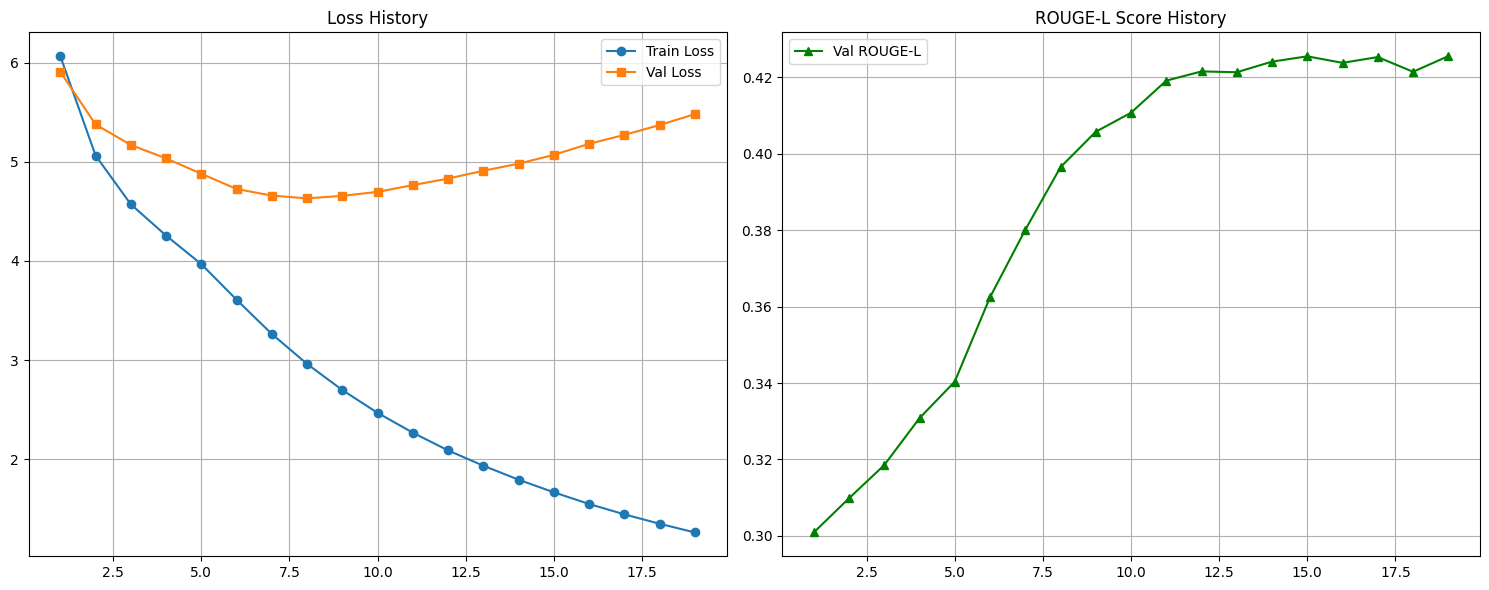

<Figure size 640x480 with 0 Axes>

In [6]:
%run /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm_Luong_attn.py